In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from matplotlib import rcParams

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() !=None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clfTree1.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)

In [3]:
df = pd.read_csv('winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1599, 12)


(array([ 10.,   0.,  53.,   0., 681.,   0., 638.,   0., 199.,  18.]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

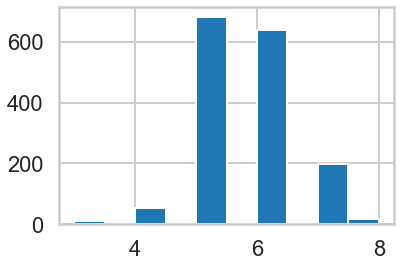

In [4]:
print (df.shape)

plt.hist(df.quality)

In [5]:
Y = df['quality'].values
df_tmp = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])
X = df_tmp.as_matrix()

df['target'] = (df['quality'].values >=7)*1

c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [6]:
Xnames = list(df.columns.values[1:11])

In [7]:
np.mean(df['target'])

0.1357098186366479

In [8]:

itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [9]:
# make sure we didn't get unlucky in our mask selection
print ("% Good wines in Training:", np.mean(df.target[mask]))
print ("% Good wines in Testing:", np.mean(df.target[~mask]))

% Good wines in Training: 0.13451511991657977
% Good wines in Testing: 0.1375


In [10]:
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 5, 'min_samples_leaf': 5} 0.40374402695659406 {'mean_fit_time': array([1.13530159e-03, 1.14889145e-03, 8.81671906e-04, 1.10487938e-03,
       7.74860382e-05, 1.71561241e-03, 5.91516495e-04, 2.39810944e-03,
       1.99413300e-04, 3.16534042e-03, 0.00000000e+00, 3.12442780e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.99017334e-04,
       0.00000000e+00, 1.91450119e-04, 2.06708908e-04, 1.91450119e-04,
       2.06708908e-04, 0.00000000e+00, 3.18145752e-03, 3.15427780e-03,
       0.00000000e+00, 0.00000000e+00, 1.99556351e-04, 0.00000000e+00,
       6.31170273e-03, 1.46341324e-04, 3.38940620e-03, 3.32703590e-03,
       3.28001976e-03, 0.00000000e+00, 3.99446487e-04, 3.14698219e-03,
       0.00000000e+00, 3.14698219e-03, 3.12404633e-03, 2.08044052e-04,
       3.15809250e-03, 3.12433243e-03]), 'std_fit_time': array([0.00068763, 0.00106604, 0.00071989, 0.0017532 , 0.00015497,
       0.00097779, 0.00076931, 0.00479622, 0.00039883, 0.00633068,
     

c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


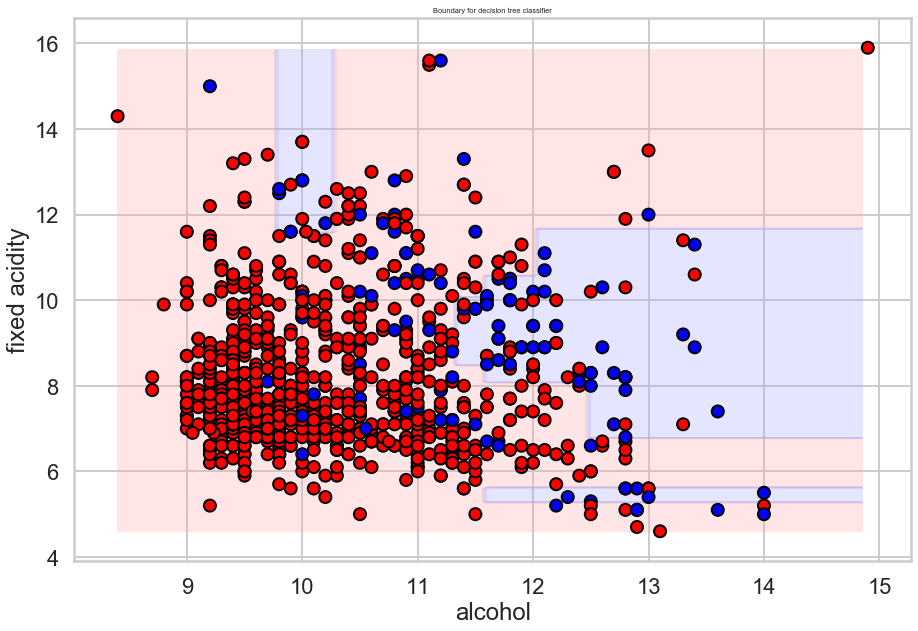

In [11]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_test = False)

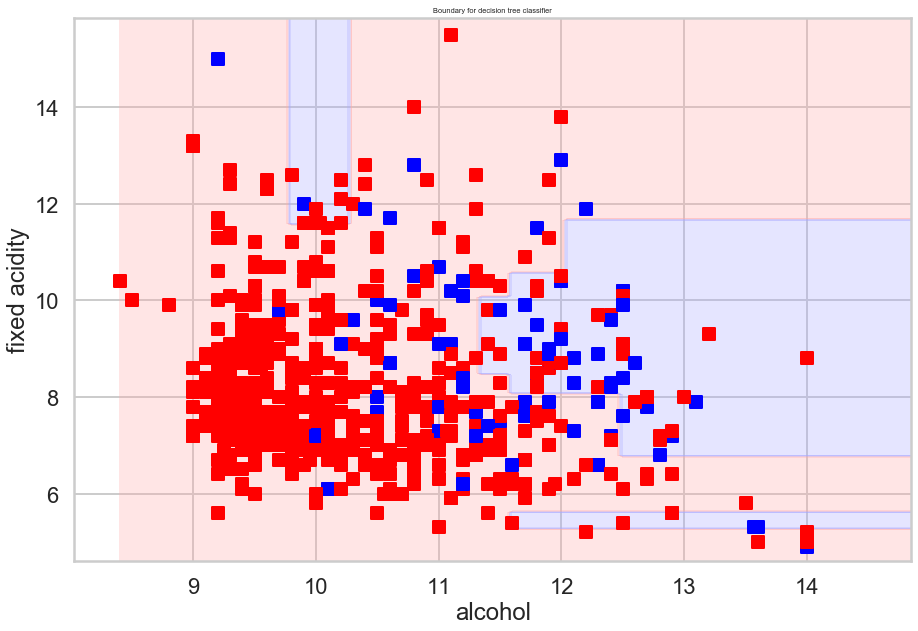

In [12]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = False)

using mask
BEST {'max_depth': None, 'min_samples_leaf': 5} 0.39270714138394724 {'mean_fit_time': array([0.00164809, 0.00262747, 0.00036001]), 'std_fit_time': array([0.0015518 , 0.00176777, 0.00072002]), 'mean_score_time': array([0.00246019, 0.0018218 , 0.00270143]), 'std_score_time': array([0.00213595, 0.00198868, 0.00176814]), 'param_max_depth': masked_array(data=[None, None, None],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[4, 5, 6],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': None, 'min_samples_leaf': 4}, {'max_depth': None, 'min_samples_leaf': 5}, {'max_depth': None, 'min_samples_leaf': 6}], 'split0_test_score': array([0.45      , 0.41025641, 0.36842105]), 'split1_test_score': array([0.31372549, 0.37288136, 0.24561404]), 'split2_test_score': array([0.56410256, 0.57142857, 0.47368421]), 'split3_test_score': array([0.4705

c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


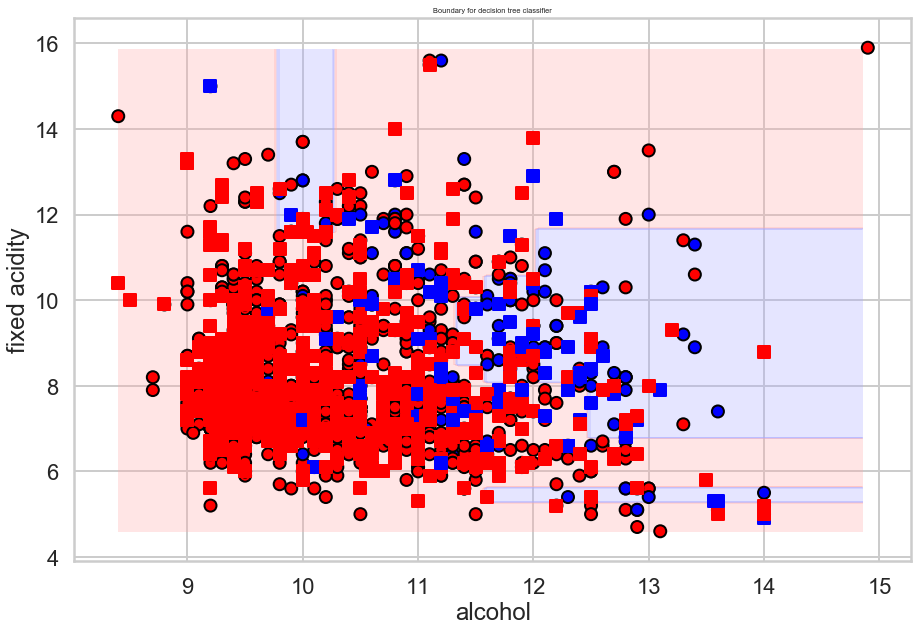

In [13]:
from sklearn import tree
clfTree_temp = tree.DecisionTreeClassifier()

parameters = {"max_depth": [None], 'min_samples_leaf': [4, 5, 6]}
clfTree_temp, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree_temp, parameters, df, 
                                                     ['alcohol', 'fixed acidity'],'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree_temp, 
           lab = ['alcohol', 'fixed acidity'], alpha = 1, plot_train = True)

In [14]:
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, df, 
                                                     Xnames,'target', 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')

using mask
BEST {'max_depth': 7, 'min_samples_leaf': 7} 0.4464888025889069 {'mean_fit_time': array([0.00140519, 0.00181985, 0.00222325, 0.00463061, 0.0013185 ,
       0.00279994, 0.00281763, 0.00160046, 0.00138593, 0.0028584 ,
       0.00298376, 0.00274487, 0.00315409, 0.00210843, 0.00406146,
       0.0032464 , 0.00216961, 0.00252047, 0.00305676, 0.00197535,
       0.00533395, 0.00507278, 0.00441146, 0.00275002, 0.00262871,
       0.00265403, 0.00496111, 0.00624847, 0.00019941, 0.00424342,
       0.00633817, 0.00963192, 0.00671506, 0.00312772, 0.00624838,
       0.00195432, 0.00624847, 0.0065556 , 0.0064712 , 0.00624971,
       0.00646653, 0.00645623, 0.00421071, 0.00338345, 0.00649929,
       0.00624857, 0.00646682, 0.00352154, 0.00502839, 0.00460825,
       0.00624971, 0.00959086, 0.00984306, 0.00846977, 0.00778618,
       0.00977435, 0.00784612, 0.00550976, 0.0034235 , 0.00991607,
       0.00628109, 0.00937333, 0.00161514, 0.00531893, 0.00313268,
       0.00681729, 0.00651526, 0.003

c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask
BEST {'n_estimators': 12} 0.4552753263166268 {'mean_fit_time': array([0.00413351, 0.00573916, 0.01327105, 0.01645956, 0.01878023,
       0.01860657, 0.02478714, 0.03192658, 0.02604585, 0.02546415,
       0.03553038, 0.03572969, 0.03459682, 0.04807696, 0.04445701,
       0.04951515, 0.0461225 , 0.04982243, 0.05505748]), 'std_fit_time': array([0.00194558, 0.00594357, 0.00261613, 0.00173808, 0.00304599,
       0.00199547, 0.00701153, 0.00116319, 0.0080601 , 0.00719202,
       0.01142571, 0.00567411, 0.00614975, 0.00124005, 0.0177688 ,
       0.00336551, 0.00488511, 0.00425814, 0.00486962]), 'mean_score_time': array([0.00396686, 0.        , 0.00396175, 0.00100513, 0.00220094,
       0.00240045, 0.00235372, 0.        , 0.00356026, 0.00664773,
       0.        , 0.00312481, 0.00625267, 0.00020828, 0.00624847,
       0.00312405, 0.00478477, 0.00771832, 0.00376902]), 'std_score_time': array([0.00218074, 0.        , 0.00363467, 0.00155961, 0.00186703,
       0.00214653, 0.00192593, 0

c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


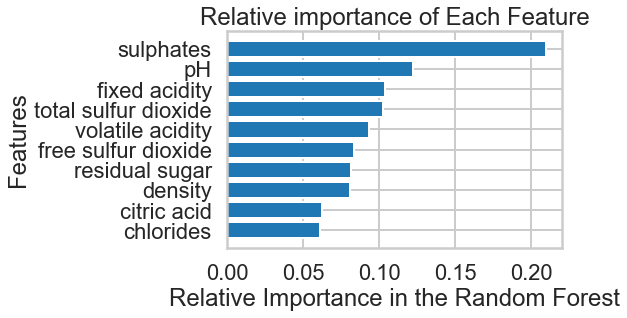

In [16]:
importance_list = clfForest.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [17]:
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask
BEST {'n_estimators': 13} 0.4797910220110747 {'mean_fit_time': array([0.04055257, 0.04334903, 0.04813151, 0.03826962, 0.05221057,
       0.05121961, 0.05069618, 0.06331873, 0.05758171, 0.06668844,
       0.07604322, 0.07604699, 0.08163214, 0.07892027, 0.0887496 ,
       0.08487239, 0.08984146, 0.08296371, 0.08578396, 0.09242425,
       0.10223866, 0.09775624, 0.10984058, 0.10875793, 0.11051912,
       0.12029586, 0.11491017, 0.11652904, 0.15731783, 0.15491948,
       0.12562728, 0.1311625 , 0.15157161, 0.13085618, 0.14336357,
       0.14858432, 0.1615778 , 0.15894585, 0.15209665, 0.1564899 ,
       0.16353211, 0.16261344, 0.16901727, 0.16768885, 0.16752806,
       0.16446142, 0.17219892, 0.18550129, 0.17771082, 0.18064752]), 'std_fit_time': array([0.00291816, 0.00618067, 0.00891985, 0.00626053, 0.00995833,
       0.00998359, 0.00823296, 0.00114153, 0.00753119, 0.00580142,
       0.01088029, 0.0107149 , 0.01542699, 0.01233391, 0.00758595,
       0.01512125, 0.0138295 , 0.0078

c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [18]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       df, Xnames, 'target', 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask


c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BEST {'max_depth': 4, 'n_estimators': 58} 0.4606321911769803 {'mean_fit_time': array([0.023313  , 0.03881669, 0.03388519, 0.02909927, 0.03246021,
       0.02292409, 0.03583169, 0.03152952, 0.03728533, 0.03813338,
       0.0306891 , 0.05241823, 0.05047827, 0.04219251, 0.04682899,
       0.04605384, 0.04684429, 0.04643459, 0.04543786, 0.04415364,
       0.05096755, 0.05374227, 0.05040107, 0.05040221, 0.05286641,
       0.06757674, 0.05402026, 0.05533643, 0.05600781, 0.06857696,
       0.04342618, 0.05659242, 0.06637678, 0.05147486, 0.04781041,
       0.0683682 , 0.06947131, 0.05115552, 0.05327301, 0.05448594,
       0.06085825, 0.06474113, 0.05539517, 0.0652174 , 0.0700007 ,
       0.06577229, 0.07245145, 0.0730731 , 0.0749558 , 0.0780158 ,
       0.08452058, 0.08792768, 0.08099337, 0.09320683, 0.08063951,
       0.07397914, 0.08859706, 0.07860584, 0.07836833, 0.08609438,
       0.06403484, 0.06615615, 0.06491027, 0.06439295, 0.06996012,
       0.07376328, 0.07324343, 0.08053489, 0.09344

############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.87
[[515  37]
 [ 48  40]]
########################################################


In [19]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]
